In [1]:
%matplotlib inline


# Is the sum of first order Sobol' indice estimates lower than 1?

https://uqworld.org/t/total-sobol-indices-sum-to-more-than-1/915


## Define the model



In [2]:
import openturns as ot
import openturns.viewer as otv

In [3]:
ot.Log.Show(ot.Log.NONE)

In [4]:
fast_simulation = True
if fast_simulation:
    sample_size = 100
    number_of_repeats_1 = 50
    number_of_repeats_2 = 100 
    number_of_repeats_3 = 100
    sample_size_3 = 500
else:
    sample_size = 1000
    number_of_repeats_1 = 500
    number_of_repeats_2 = 1000
    number_of_repeats_3 = 1000
    sample_size_3 = 5000

In [5]:
distributionX = ot.Normal(3)

In [6]:
model = ot.SymbolicFunction(["a", "b", "c"], ["1.0 + 2.0 * a + 3.0 * b + 4.0 * c"])

In [7]:
input_names = distributionX.getDescription()

In [8]:
for repeat in range(10):
    sie = ot.SobolIndicesExperiment(distributionX, sample_size)
    inputDesign = sie.generate()
    input_names = distributionX.getDescription()
    inputDesign.setDescription(input_names)
    outputDesign = model(inputDesign)
    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(
        inputDesign, outputDesign, sample_size
    )
    first_order_indices = sensitivityAnalysis.getFirstOrderIndices()
    print("Repeat #", repeat, "sum=", sum(first_order_indices))

Repeat # 0 sum= 1.123500041075805
Repeat # 1 sum= 1.0702818973371149
Repeat # 2 sum= 1.1203155685780468
Repeat # 3 sum= 1.0861222196199147
Repeat # 4 sum= 1.0778361583389922
Repeat # 5 sum= 1.1115692098010137
Repeat # 6 sum= 0.9265738817145954
Repeat # 7 sum= 1.0952475215929827
Repeat # 8 sum= 1.1366878415867956
Repeat # 9 sum= 0.933840396948489


In [9]:
def getFirstOrderIndicesSample(
    distributionX, model, sample_size=1000, number_of_repeats=1000
):
    """
    Create a sample of first order indices.
    
    We consider three random variables.
    * S : the first order indice
    * O : the sum of first order indices
    * B : one if O is greater than one, zero otherwise.
    
    Parameters
    ----------
    distributionX : ot.Distribution
        The input distribution.
    model : ot.Function
        The model
    sample_size : int
        The size of the design of experiment to estimate one 
        realization of the first order indices.
    number_of_repeats : int
        The number of repetitions in the sample.

    Returns
    -------
    sample_S : ot.Sample(number_of_repeats, dimension)
        The sample of first order indices.
    sample_B : ot.Sample(number_of_repeats, 1)
        The sample of first order indices.
    sample_O : ot.Sample(number_of_repeats, 1)
        The sample of first order indices.
    """
    dimension = distributionX.getDimension()
    sample_S = ot.Sample(number_of_repeats, dimension)
    sample_S.setDescription([r"$S_i%d$" for i in range(dimension)])
    sample_B = ot.Sample(number_of_repeats, 1)
    sample_B.setDescription([r"$B$"])
    sample_O = ot.Sample(number_of_repeats, 1)
    sample_O.setDescription([r"$O$"])
    for repeat in range(number_of_repeats):
        sie = ot.SobolIndicesExperiment(distributionX, sample_size)
        inputDesign = sie.generate()
        input_names = distributionX.getDescription()
        inputDesign.setDescription(input_names)
        outputDesign = model(inputDesign)
        sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(
            inputDesign, outputDesign, sample_size
        )
        first_order_indices = sensitivityAnalysis.getFirstOrderIndices()
        sample_S[repeat] = first_order_indices
        sample_O[repeat, 0] = sum(first_order_indices)
        sample_B[repeat, 0] = int(sample_O[repeat, 0] > 1.0)
    return sample_S, sample_O, sample_B

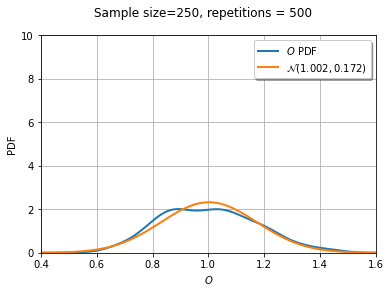

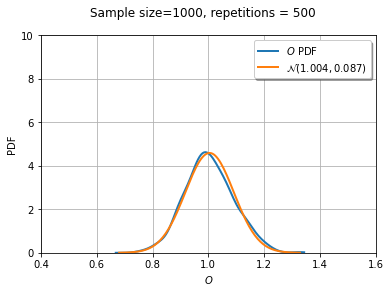

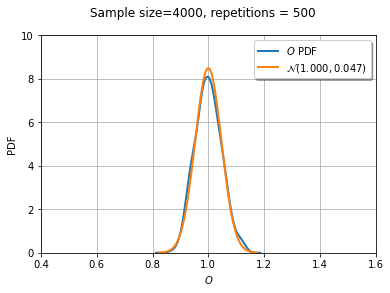

In [10]:
for sample_size in [250, 1000, 4000]:
    sample_S, sample_O, sample_B = getFirstOrderIndicesSample(
        distributionX, model, sample_size, number_of_repeats_1
    )
    graph = ot.KernelSmoothing().build(sample_O).drawPDF()
    mu_hat = sample_O.computeMean()[0]
    sigma_hat = sample_O.computeStandardDeviation()[0]
    gaussian = ot.Normal(mu_hat, sigma_hat)
    curve = gaussian.drawPDF()
    curve.setLegends([r"$\mathcal{N}(%.3f, %.3f)$" % (mu_hat, sigma_hat)])
    graph.add(curve)
    graph.setColors(ot.Drawable_BuildDefaultPalette(2))
    graph.setTitle(
        "Sample size=%d, repetitions = %d" % (sample_size, number_of_repeats_1)
    )
    interval = ot.Interval([0.4, 0.0], [1.6, 10.0])
    graph.setBoundingBox(interval)
    otv.View(graph)

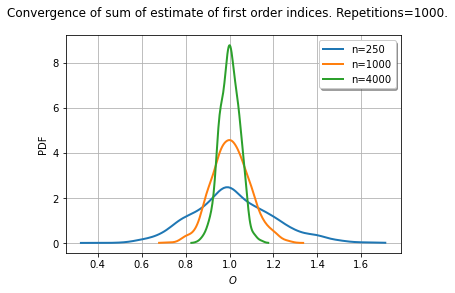

In [11]:
graph = ot.Graph(
    "Convergence of sum of estimate of first order indices. Repetitions=%d."
    % (number_of_repeats_2),
    r"$O$",
    "PDF",
    True,
)
for sample_size in [250, 1000, 4000]:
    sample_S, sample_O, sample_B = getFirstOrderIndicesSample(
        distributionX, model, sample_size, number_of_repeats_2
    )
    curve = ot.KernelSmoothing().build(sample_O).drawPDF()
    curve.setLegends(["n=%d" % (sample_size)])
    graph.add(curve)
graph.setColors(ot.Drawable_BuildDefaultPalette(3))
graph.setLegendPosition("topright")
_ = otv.View(graph)

In [12]:
sample_S, sample_O, sample_B = getFirstOrderIndicesSample(
    distributionX, model, sample_size_3, number_of_repeats_3
)

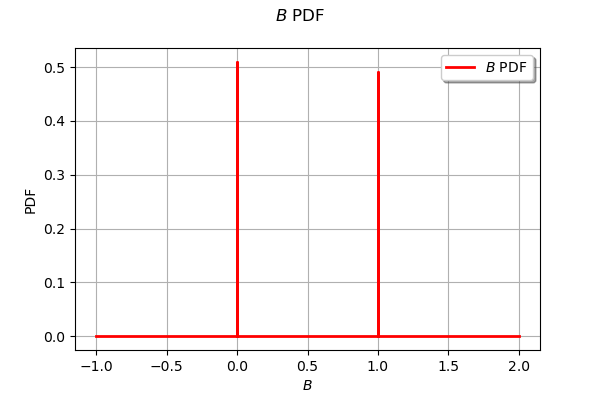

In [13]:
ot.UserDefined(sample_B).drawPDF()

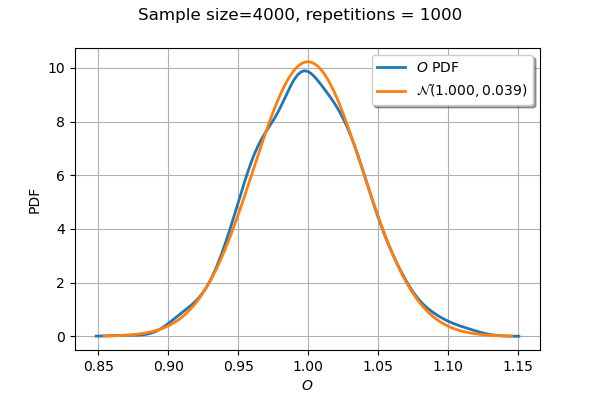

In [14]:
graph = ot.KernelSmoothing().build(sample_O).drawPDF()
mu_hat = sample_O.computeMean()[0]
sigma_hat = sample_O.computeStandardDeviation()[0]
gaussian = ot.Normal(mu_hat, sigma_hat)
curve = gaussian.drawPDF()
curve.setLegends([r"$\mathcal{N}(%.3f, %.3f)$" % (mu_hat, sigma_hat)])
graph.add(curve)
graph.setColors(ot.Drawable_BuildDefaultPalette(2))
graph.setTitle("Sample size=%d, repetitions = %d" % (sample_size, number_of_repeats_3))
graph

For one sample, compute the asymptotic distribution of the indices. The `getFirstOrderIndicesDistribution` uses the Delta-method. 

In [15]:
sie = ot.SobolIndicesExperiment(distributionX, sample_size)
inputDesign = sie.generate()
input_names = distributionX.getDescription()
inputDesign.setDescription(input_names)
outputDesign = model(inputDesign)
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(
    inputDesign, outputDesign, sample_size
)
sensitivityAnalysis.setUseAsymptoticDistribution(True)
first_order_indices = sensitivityAnalysis.getFirstOrderIndices()
first_order_distribution = sensitivityAnalysis.getFirstOrderIndicesDistribution()
first_order_distribution

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[0.11577,0.298935,0.552886] sigma=class=Point name=Unnamed dimension=3 values=[0.0161047,0.0179677,0.0221247] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0,0,0,1,0,0,0,1]

Create the asymptotic distribution associated with the sum. We just sum the Gaussians, and let OpenTURNS handle the distribution, based on the arithmetic of Gaussians. 

In [16]:
dimension = distributionX.getDimension()
first_order_sum_distribution = first_order_distribution.getMarginal(0)
for i in range(1, dimension):
    first_order_sum_distribution += first_order_distribution.getMarginal(
        i
    )  # Add the i-th marginal to the sum
first_order_sum_distribution

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0.967591] sigma=class=Point name=Unnamed dimension=1 values=[0.0327369] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

We see that the mean of the gaussian is close to 1, but is not strictly equal to 1. This is because this asymptotic distribution is for one single sample: it is itself a random variable. What matters most is the variance of this Gaussian: the goal is to correctly assess the variance of the estimator. This is why we set the mean to the exact value. 

In [17]:
parameters = first_order_sum_distribution.getParameter()
parameters[0] = 1.0
first_order_sum_distribution.setParameter(parameters)
first_order_sum_distribution

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[1] sigma=class=Point name=Unnamed dimension=1 values=[0.0327369] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

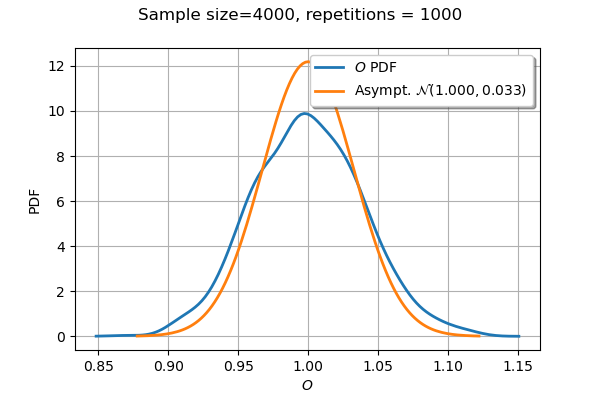

In [18]:
graph = ot.KernelSmoothing().build(sample_O).drawPDF()
mu_hat = sample_O.computeMean()[0]
sigma_hat = sample_O.computeStandardDeviation()[0]
gaussian = ot.Normal(mu_hat, sigma_hat)
curve = first_order_sum_distribution.drawPDF()
mu_hat = first_order_sum_distribution.getMean()[0]
sigma_hat = first_order_sum_distribution.getStandardDeviation()[0]
curve.setLegends([r"Asympt. $\mathcal{N}(%.3f, %.3f)$" % (mu_hat, sigma_hat)])
graph.add(curve)
graph.setColors(ot.Drawable_BuildDefaultPalette(2))
graph.setTitle("Sample size=%d, repetitions = %d" % (sample_size, number_of_repeats_3))
graph

We see that the variance of the estimator predicted by the asymptotic distribution is smaller than the actual variance: the asymptotic distribution underestimates the variance. This conclusion is however, only valid for this particular sample: the variance of the asymptotic distribution is itself a random variable. This might, however, indicate a general fact. The cause of this might be that the delta-method was used without taking into account for the variance of the mean used to center the model. In order to make sure of this, we should have the exact variance of the estimator and compare it with its asymptotic estimator. This should be doable for a linear model, using regression theory. 